<a href="https://colab.research.google.com/github/haniehghaffari/Deep_learning/blob/main/yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
import numpy as np
import pandas as pd
import cv2

In [88]:
def load_data_and_preprocess(path):
    img = cv2.imread(path)
    h,w = img.shape[:2]
    pre_processed_image = cv2.dnn.blobFromImage(img,scalefactor = 1/255.0 , 
                                               size = (416,416),swapRB = True ,crop =False)
    return img, pre_processed_image,h,w

In [128]:
img, pre_processed_image,h,w = load_data_and_preprocess('/content/drive/MyDrive/yasin.jpg')

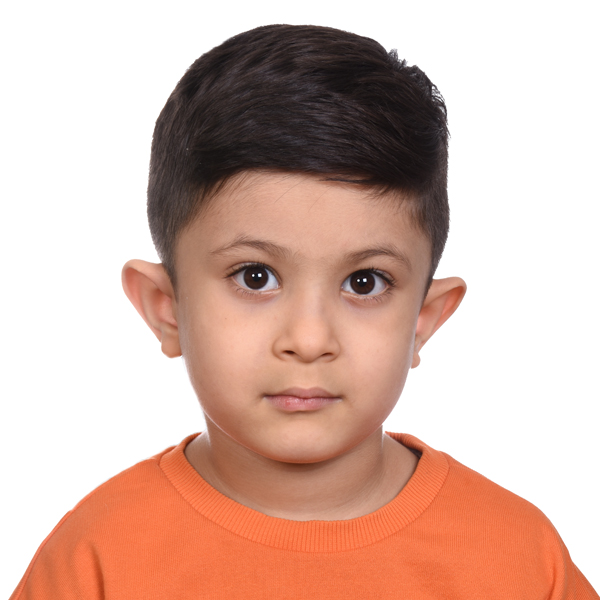

In [131]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [132]:
def load_model_and_labels(label_address):
    config = r'/content/drive/MyDrive/yolo files/yolo files/yolov3.cfg'
    weight = r'/content/drive/MyDrive/yolo files/yolo files/yolov3.weights'
    labels = open(label_address).read().strip().split('\n')
    net = cv2.dnn.readNet(config,weight)
    return labels ,net

In [133]:
labels,net = load_model_and_labels(r'/content/drive/MyDrive/yolo files/yolo files/coco.names')
print(labels)


['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [134]:
# def inference(pre_processed_image,h,w,net,labels):
#     net.setInput(pre_processed_image)
#     layer_names = net.getLayerNames()
# #     print(layer_names)
#     output_layers = ['yolo_82','yolo_94','yolo_106']
#     predictions = net.forward(output_layers)
#     return predictions

In [135]:
# predictions = inference(pre_processed_image,h,w,net,labels)
# predictions

In [136]:
def inference(pre_processed_image,h,w,net,labels):
    net.setInput(pre_processed_image)
    layer_names = net.getLayerNames()
    # print(layer_names)
    output_layers = ['yolo_82','yolo_94','yolo_106']
    predictions = net.forward(output_layers)
    return predictions

In [137]:
predictions = inference(pre_processed_image,h,w,net,labels)
predictions

[array([[0.04835775, 0.03488615, 0.25763568, ..., 0.        , 0.        ,
         0.        ],
        [0.05970462, 0.03995166, 0.22203088, ..., 0.        , 0.        ,
         0.        ],
        [0.05258143, 0.02482519, 1.0175378 , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.9596341 , 0.95838505, 0.4409935 , ..., 0.        , 0.        ,
         0.        ],
        [0.9664783 , 0.96480465, 0.30006522, ..., 0.        , 0.        ,
         0.        ],
        [0.96894526, 0.96206295, 0.84505856, ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 array([[0.02343928, 0.0295513 , 0.05307031, ..., 0.        , 0.        ,
         0.        ],
        [0.0209427 , 0.02842782, 0.20549454, ..., 0.        , 0.        ,
         0.        ],
        [0.02815107, 0.02277305, 0.08938146, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.9765205 , 0.9757626 , 0.04400855, ..., 0.        , 0.        ,
         0.        

In [138]:
def post_preprocessing(predictions,w,h):
    
    classIDs = []
    confidences = []
    boxes = []
    
    
    for layer in predictions:
        for detected_object in layer :
            scores = detected_object[5:]
            classID=np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.3 :
#                 print(confidences)
                box = detected_object[0:4] * np.array([w,h,w,h])
                (centerX,centerY,width,height) = box.astype('int')
                x = int(centerX - width/2)
                y = int(centerY - height/2)
                classIDs.append(classID)
                confidences.append(float(confidence))
                boxes.append([x,y,int(w),int(h)])
    return classIDs,confidences,boxes

In [139]:
classIDs,confidences,boxes = post_preprocessing(predictions,w,h)


In [140]:
def show_result(img,classIDs,confidences , boxes,labels):
    
    idxs = cv2.dnn.NMSBoxes(boxes,confidences,0.3,0.5)
    print(len(boxes))
    print(idxs)
    # if len(idxs) > 0:
    for i in idxs.flatten():
        (x,y)= boxes[i][0],boxes[i][1]
        (w,h)= boxes[i][2],boxes[i][3]        
        
        
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
        text = '{}:{:.2f}'.format(labels[classIDs[i]],confidences[i])
        cv2.putText(img,text,(x,x-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),2)
        
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [141]:
# from google.colab.patches import cv2_imshow
# cv2_imshow(img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
1
[[0]]


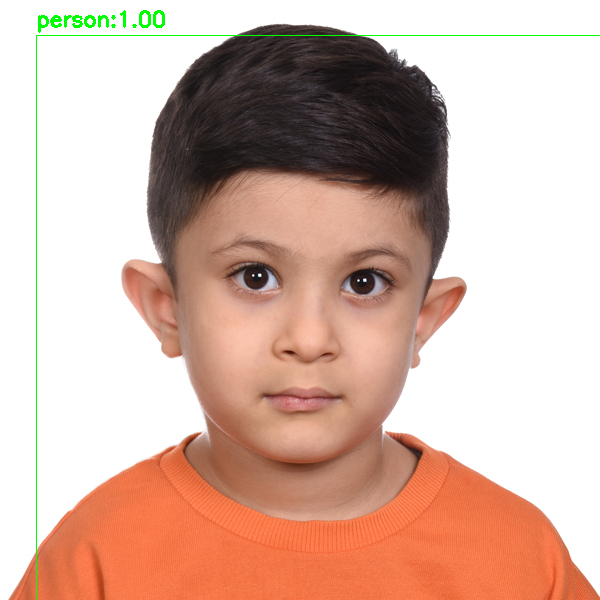

In [142]:
%time
show_result(img,classIDs,confidences , boxes,labels)